reference:
    
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# 0. Importing Packages

In [11]:
import numpy as np
from numpy import array, hstack
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns


from datetime import datetime, timedelta


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.utils import shuffle

from sklearn import preprocessing

rcParams['figure.figsize'] = 20, 6

In [13]:
from keras.models import load_model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import re


Using TensorFlow backend.


# 1. Loading Data

In [14]:
# Getting all the files in the directory.
def existing_file_list(path):
    ''' Extracting File Names '''

    allFiles = glob.glob(path + "/*.csv")
    new_list = []
    for i in allFiles:
        before = 'original\\'
        after = '_minute'
        ticker = i[i.find(before) + len(before) : i.find(after)]
        new_list.append(ticker)    
    #list_ticker = list(filter(None, text))  # drop all the empty elements and put them in a list
        
    return (new_list)


In [15]:
datapath = 'D:\\OneDrive - Georgia State University\\Data Science\\Personal_Project\\FPL_Analysis\\Data\\Final\\'

from os import listdir
from os.path import isfile, join
main_data_list = [f for f in listdir(datapath) if isfile(join(datapath, f))]

In [16]:
datapath

'D:\\OneDrive - Georgia State University\\Data Science\\Personal_Project\\FPL_Analysis\\Data\\Final\\'

In [17]:
main_data_list

['bootstrap.xlsx',
 'by_player.csv',
 'by_position.csv',
 'by_team.csv',
 'elements.xlsx',
 'element_types.xlsx',
 'merged_gw.csv',
 'next_event_fixtures.xlsx',
 'teams.xlsx',
 '~$bootstrap.xlsx',
 '~$teams.xlsx']

In [18]:
#element_types = pd.read_csv(datapath + 'element_types.xlsx',index_col='id', engine = 'python')
bootstrap = pd.read_excel(datapath + 'bootstrap.xlsx',index_col='id')
main_data = pd.read_csv(datapath + 'merged_gw.csv', index_col=['id', 'fixture'], engine = 'python')
teams = pd.read_excel(datapath + 'teams.xlsx',index_col='id')

by_team =  pd.read_csv(datapath + 'by_team.csv', engine = 'python')
by_position =  pd.read_csv(datapath + 'by_position.csv', engine = 'python')
by_player =  pd.read_csv(datapath + 'by_player.csv', engine = 'python')


In [19]:
main_data.sort_index(inplace=True)
bootstrap.sort_index(inplace=True)
teams.sort_index(inplace=True)

# 2. Preprocessing

In this section, I will prepare the dataset for feeding into LSTM network. Basically, I will do 4 things.

1. Transform data to stationary
2. Transform data to supervised learning
3. Split the data into train and test
4. Scale the data to (-1,1)

# 3) Splitting Data

## 3-1) Prepare Features and Labels  

In [21]:
def create_train_test(data):
    '''Create training and validation features and labels'''
    data = shuffle(data)
    a = round(len(data)*0.7)
    
    train, test = data.iloc[:a], data.iloc[a:]
    
    return train, test

In [22]:
def normalization(data):
    '''normalizing the data'''
    
    scaler = preprocessing.MinMaxScaler()
    if len(data.columns) == 1:
        data = data.values.reshape(-1, 1)
    else:
        pass
    
    scaled = scaler.fit_transform(data)
    #scaled = pd.DataFrame(scaled, columns=data.columns, index = data.index)
    
    return scaled, scaler

In [23]:
main_data = main_data.drop('name', axis=1)

train, test = create_train_test(main_data)
normalized_train, scaler = normalization(train)
normalized_test, scaler = normalization(test)


D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3-2) Reshape features

In [24]:
# multivariate data preparation

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
        
    
    return array(X), array(y)

In [25]:
# choose a number of time steps
n_steps = 13

# convert into input/output
x_train_reshaped, y_train = split_sequences(normalized_train, n_steps)
x_test_reshaped, y_test = split_sequences(normalized_test, n_steps)



In [26]:
print (f"shape of x_train_reshaped: {x_train_reshaped.shape}, \nshape of y_train: {y_train.shape}, \n\nshape of x_test_reshaped: {x_test_reshaped.shape}, \nshape of y_test: {y_test.shape}")

shape of x_train_reshaped: (15241, 13, 47), 
shape of y_train: (15241,), 

shape of x_test_reshaped: (6525, 13, 47), 
shape of y_test: (6525,)


In [27]:
x_train_reshaped[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.32075472e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.70270270e-02, 0.00000000e+00, 2.68147830e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.33333333e-01, 0.00000000e+00, 1.60000000e-01, 5.84958266e-01,
        1.30540315e-02, 5.37621595e-03, 7.14285714e-02, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.26315789e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.32075472e-01, 0.00000000e+00, 0.00000000e+00,
       

# 4) Build and Train a Model

In [28]:
n_timesteps, n_features, n_outputs = x_train_reshaped.shape[1], x_train_reshaped.shape[2], 1

print (f"shape of number of timesteps: {n_timesteps} \nnumber of features: {n_features} \nnumber of outputs: {n_outputs}")

shape of number of timesteps: 13 
number of features: 47 
number of outputs: 1


## 4-1) First Model

In [29]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')"

In [30]:
# define model
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_timesteps, n_features)))
model_CNN.add(MaxPooling1D(pool_size=1))
model_CNN.add(Flatten())
model_CNN.add(Dense(50, activation='relu'))
model_CNN.add(Dense(1))
model_CNN.compile(optimizer='adam', loss='mse')

In [31]:
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 64)            3072      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 832)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                41650     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 44,773
Trainable params: 44,773
Non-trainable params: 0
_________________________________________________________________


In [32]:
epochs = 700
batch_size = 128
verbose = 1
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [33]:
# fit network
history = model_CNN.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.2, callbacks=callbacks)

Train on 12192 samples, validate on 3049 samples
Epoch 1/700
12192/12192 [==============================] - 1s 66us/step - loss: 0.0827 - val_loss: 0.0736
Epoch 2/700
12192/12192 [==============================] - 0s 29us/step - loss: 0.0658 - val_loss: 0.0699
Epoch 3/700
12192/12192 [==============================] - 0s 28us/step - loss: 0.0596 - val_loss: 0.0649
Epoch 4/700
12192/12192 [==============================] - 0s 27us/step - loss: 0.0550 - val_loss: 0.0611
Epoch 5/700
12192/12192 [==============================] - 0s 27us/step - loss: 0.0517 - val_loss: 0.0625
Epoch 6/700
12192/12192 [==============================] - 0s 41us/step - loss: 0.0494 - val_loss: 0.0608
Epoch 7/700
12192/12192 [==============================] - 0s 29us/step - loss: 0.0463 - val_loss: 0.0596
Epoch 8/700
12192/12192 [==============================] - 0s 26us/step - loss: 0.0434 - val_loss: 0.0594
Epoch 9/700
12192/12192 [==============================] - 0s 26us/step - loss: 0.0419 - val_loss: 0.06

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

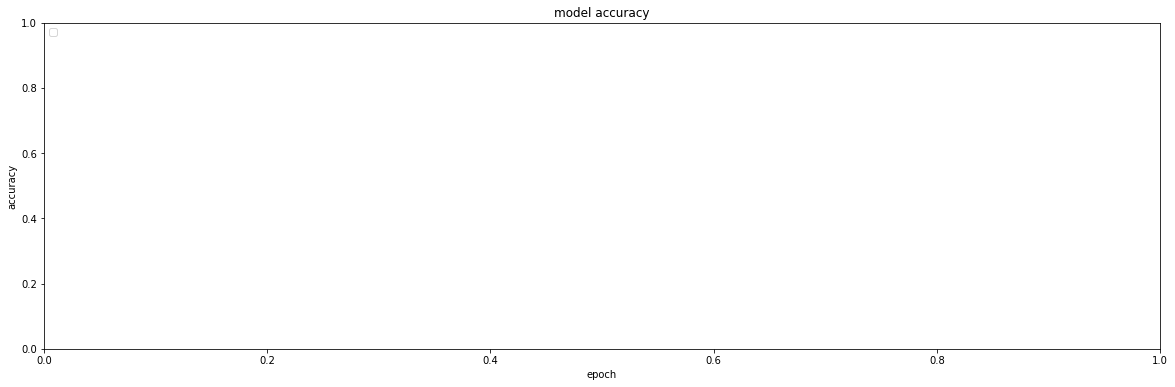

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

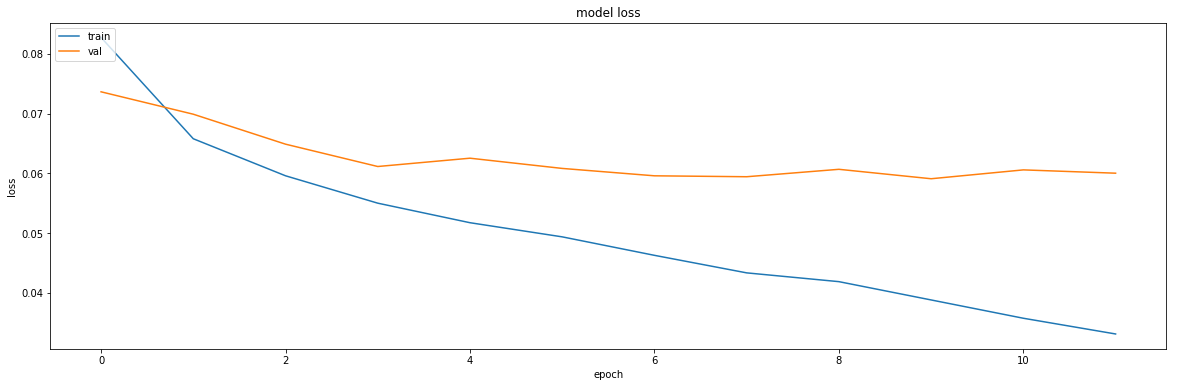

In [34]:
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
'''# Returns a compiled model identical to the previous one
model = load_model('E:\Data Science\Personal_Project\RNN - Solar Farm\model\LSTM_Model.h5')

y_predict = model.predict(x_test_reshaped, verbose)'''

"# Returns a compiled model identical to the previous one\nmodel = load_model('E:\\Data Science\\Personal_Project\\RNN - Solar Farm\\model\\LSTM_Model.h5')\n\ny_predict = model.predict(x_test_reshaped, verbose)"

In [36]:
history.history['loss']

[0.08273699249964686,
 0.06579190475030208,
 0.05959545427889336,
 0.055013088514329254,
 0.0517434707776768,
 0.04937638774553309,
 0.04628568127008248,
 0.04335137456655502,
 0.041881659368830405,
 0.03882027480976162,
 0.03575801324304633,
 0.033127419806997294]

In [37]:
y_predict = model_CNN.predict(x_test_reshaped, verbose)
y_predict = y_predict.reshape(y_predict.shape[0],)

In [38]:
comparison = pd.DataFrame(data=np.column_stack((y_test,y_predict)),columns=['actual','prediction'])
comparison = comparison.set_index(test.index[n_steps-1:])

In [39]:
denormalizing_data = main_data.copy()
denormalizing_data.drop(columns = ['total_points'], inplace = True)
denormalizing_data['prediction'] = comparison['prediction']
denormalizing_data.dropna(axis=0,inplace=True)
denormalized_prediction = pd.DataFrame(scaler.inverse_transform(denormalizing_data), index=test.index[n_steps-1:], columns=denormalizing_data.columns)['prediction']

denormalizing_actual = main_data.copy()
denormalizing_actual.drop(columns = ['total_points'], inplace = True)
denormalizing_actual['actual'] = comparison['actual']
denormalizing_actual.dropna(axis=0,inplace=True)
denormalized_actual = pd.DataFrame(scaler.inverse_transform(denormalizing_actual), index=test.index[n_steps-1:], columns=denormalizing_actual.columns)['actual']

comparison = pd.concat([denormalized_actual, denormalized_prediction], axis=1)

In [40]:
comparison

,,actual,prediction
id,fixture,,
245,25,1.0,0.925337
202,115,1.0,3.231236
524,136,1.0,2.984201
250,237,1.0,2.574267
563,220,1.0,2.936040
441,104,1.0,2.642894
284,330,1.0,3.020569
184,245,1.0,2.687039
88,154,1.0,2.728923


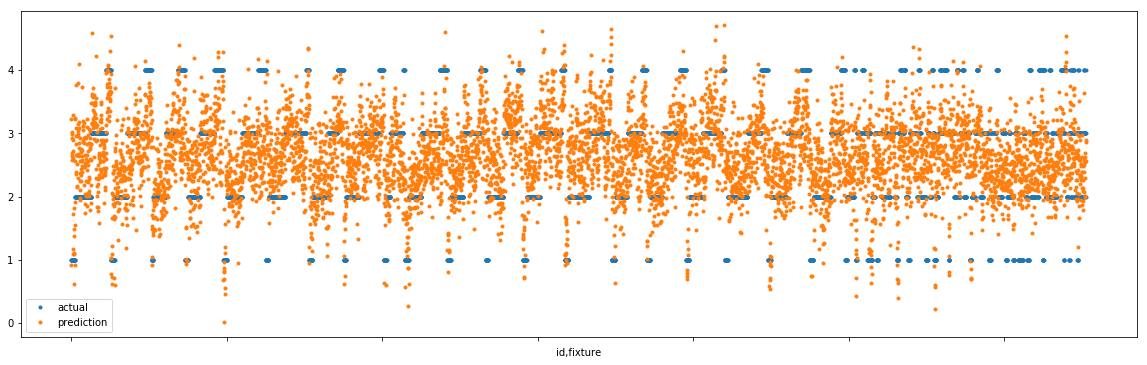

In [42]:
comparison.plot(style=['.','.'])

In [122]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
new_df = comparison
mse = mean_squared_error(new_df['actual'], new_df['prediction'])
mape = mean_absolute_percentage_error(new_df['actual'], new_df['prediction'])
mae = mean_absolute_error(new_df['actual'], new_df['prediction'])

#mean 

print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}')  


RMSE: 47.89844692915446
MAE: 20.703022823489544


D:\Programming\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [81]:
# Saving the result
comparison.to_csv(mypath + 'Result\\CNN_' + str(round((mae), 4)) + '.csv', index = True)

In [82]:
# Creates a HDF5 file 'my_model.h5'
model_CNN.save(mypath + 'Model\\CNN_' + str(round((mae), 4))  + '.h5')

# Deletes the existing model
# del model  


# For Improvements: